# Environment preparation

In [ ]:
!pip install tensorflow scikit-learn matplotlib numpy


In [1]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))



Num GPUs Available:  1
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0



In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
from tensorflow.keras import mixed_precision

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)

    # Enable mixed precision
    mixed_precision.set_global_policy('mixed_float16')
  except RuntimeError as e:
    print(e)
else:
  print('No GPU found')

# Data loading

In [4]:
import tensorflow as tf

image_side_size = 100
image_size = (image_side_size, image_side_size)
batch_size = 128
base_path = f'/content/drive/My Drive/Lucas/TCC/data/segmented_images/{image_side_size}x{image_side_size}'
#base_path = '/content/drive/My Drive/Personal/MBA/data/segmented_images/'

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_path,
    image_size=image_size,  # Resize images to 100x100 pixels
    batch_size=batch_size,  # Adjust the batch size as needed
    label_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=True,  # Shuffle data to ensure randomness
    validation_split=0.2,  # Use 20% of the data for validation
    subset="training",  # This is the training subset
    seed=123  # Fix seed to ensure consistent shuffling
)

# Load the validation set as well
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_path,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
    validation_split=0.2,
    subset="validation",  # This is the validation subset
    seed=123
)

# Check the class names
print(f"Class names: {dataset.class_names}")

Found 11109 files belonging to 6 classes.
Using 8888 files for training.
Found 11109 files belonging to 6 classes.
Using 2221 files for validation.
Class names: ['asch', 'ascus', 'hsil', 'lsil', 'normal', 'scc']


In [5]:
# Print data distribution
import numpy as np
import matplotlib.pyplot as plt

# Initialize a dictionary to store the class counts
class_counts = {class_name: 0 for class_name in dataset.class_names}

# Iterate through the dataset to count occurrences of each class
for images, labels in dataset:
    labels = np.argmax(labels.numpy(), axis=1)  # Convert one-hot encoded labels to class indices
    for label in labels:
        class_name = dataset.class_names[label]
        class_counts[class_name] += 1




In [6]:
# Count the number of occurrences of each class in the validation dataset
val_class_counts = {class_name: 0 for class_name in dataset.class_names}
for images, labels in val_dataset:
    labels = np.argmax(labels.numpy(), axis=1)  # Convert one-hot encoded labels to class indices
    for label in labels:
        class_name = dataset.class_names[label]
        val_class_counts[class_name] += 1


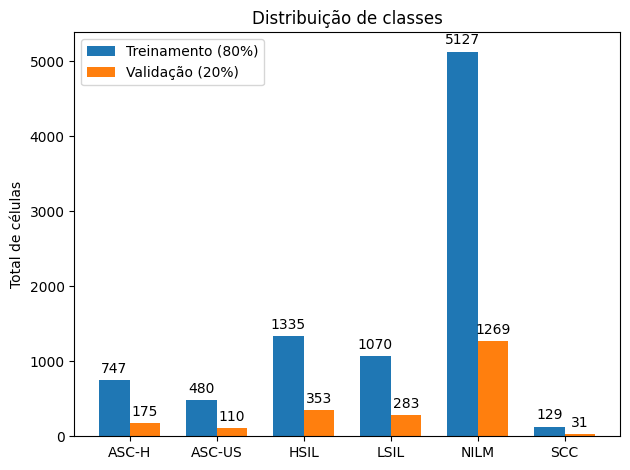

In [7]:
# Create a bar plot comparing training and validation counts for each class
labels = ['ASC-H', 'ASC-US', 'HSIL', 'LSIL', 'NILM', 'SCC']#list(class_counts.keys())  # Class names
train_counts = list(class_counts.values())  # Training class counts
val_counts = list(val_class_counts.values())  # Validation class counts

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_counts, width, label='Treinamento (80%)')
rects2 = ax.bar(x + width/2, val_counts, width, label='Validação (20%)')

# Add labels, title, and custom x-axis labels
#ax.set_xlabel('Classes')
ax.set_ylabel('Total de células')
ax.set_title('Distribuição de classes')
ax.set_xticks(x)
ax.set_xticklabels(labels)  # Custom class labels for x-axis
ax.legend()

# Function to add the exact number on top of bars
def autolabel(rects):
    """Attach a text label above each bar, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add text labels on bars
autolabel(rects1)
autolabel(rects2)

# Show plot
plt.tight_layout()
plt.show()


Distribuição das classes
asch: 747
ascus: 480
hsil: 1335
lsil: 1070
normal: 5127
scc: 129


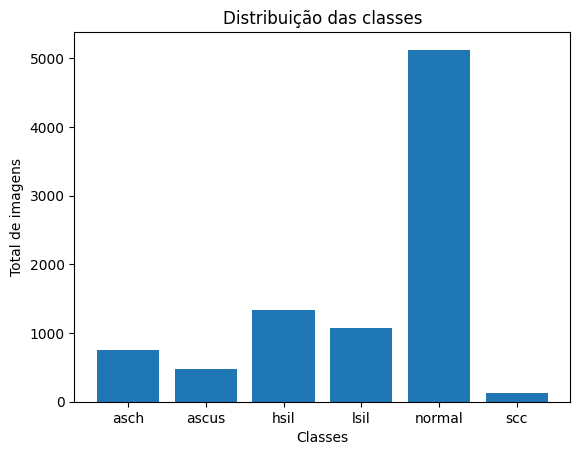

In [8]:
# Print class counts
print("Distribuição das classes")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

# Plot a bar chart of the class distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Total de imagens')
plt.title('Distribuição das classes')
#plt.xticks(rotation=45)
plt.show()

## Augmentation

In [9]:
import tensorflow as tf

# List of minority classes (asch, ascus, scc)
minority_classes = ['asch', 'ascus', 'scc']
minority_class_indices = [dataset.class_names.index(cls) for cls in minority_classes]

# Unbatch the dataset to process individual images
unbatched_dataset = dataset.unbatch()

# Function to check if the label belongs to one of the minority classes
def is_minority_class(image, label):
    # Check if the label belongs to the minority classes
    return tf.reduce_any(tf.math.equal(tf.argmax(label, axis=-1), minority_class_indices))

# Filter to keep only the minority classes
minority_dataset = unbatched_dataset.filter(is_minority_class)

# Define augmentation function for a single image
def augment_single_image(image):
    # Apply random rotations (90º, 180º, 270º)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Apply random horizontal and vertical flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Apply zoom by scaling and resizing (alternative to random_crop)
    scaling_factor = tf.random.uniform([], minval=0.8, maxval=1.2, dtype=tf.float32)
    new_size = tf.cast(scaling_factor * 100, tf.int32)

    # Resize the image by scaling factor and then resize back to original size
    image = tf.image.resize(image, [new_size, new_size])
    image = tf.image.resize_with_crop_or_pad(image, 100, 100)  # Ensure the size remains 100x100

    return image

# Apply augmentation to the minority class dataset
augmented_minority_dataset = minority_dataset.map(lambda image, label: (augment_single_image(image), label))

# Re-batch the dataset after augmentation
augmented_minority_dataset = augmented_minority_dataset.batch(32)

# Concatenate the original and augmented datasets
final_dataset = dataset.concatenate(augmented_minority_dataset)

# Prefetch and shuffle the final dataset
final_dataset = final_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Class distribution in the final dataset (after augmentation):
asch: 1494
ascus: 960
hsil: 1335
lsil: 1070
normal: 5127
scc: 258


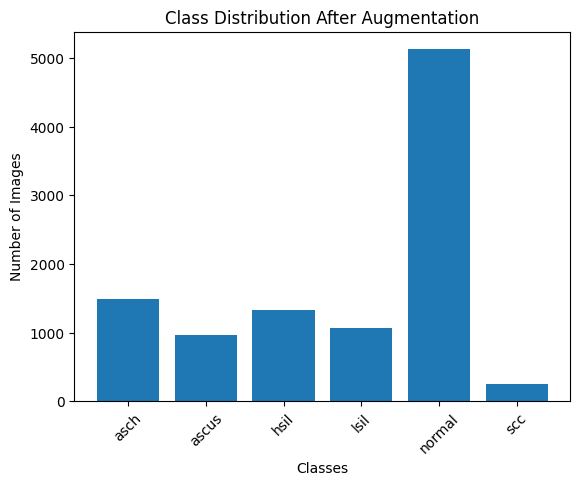

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize a dictionary to store the class counts
class_counts = {class_name: 0 for class_name in dataset.class_names}

# Iterate through the final_dataset to count occurrences of each class
for images, labels in final_dataset:
    labels = np.argmax(labels.numpy(), axis=1)  # Convert one-hot encoded labels to class indices
    for label in labels:
        class_name = dataset.class_names[label]
        class_counts[class_name] += 1

# Print class counts
print("Class distribution in the final dataset (after augmentation):")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

# Plot a bar chart of the class distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution After Augmentation')
plt.xticks(rotation=45)
plt.show()


In [11]:
class_factor = {
    'asch': (class_counts['normal']/class_counts['asch']) - 1,
    'ascus': (class_counts['normal']/class_counts['ascus']) - 1,
    'hsil': (class_counts['normal']/class_counts['hsil']) - 1,
    'lsil': (class_counts['normal']/class_counts['lsil']) - 1,
    'scc': (class_counts['normal']/class_counts['scc']) - 1
}

class_factor

{'asch': 2.431726907630522,
 'ascus': 4.340625,
 'hsil': 2.8404494382022474,
 'lsil': 3.791588785046729,
 'scc': 18.872093023255815}

In [12]:
import tensorflow as tf
import numpy as np

# List of minority classes (asch, ascus, scc)
minority_classes = ['asch', 'ascus', 'hsil', 'lsil', 'scc']
minority_class_indices = [dataset.class_names.index(cls) for cls in minority_classes]

# Unbatch the dataset to process individual images
unbatched_dataset = dataset.unbatch()

# Function to check if the label belongs to one of the minority classes
def is_minority_class(image, label):
    # Check if the label belongs to the minority classes
    return tf.reduce_any(tf.math.equal(tf.argmax(label, axis=-1), minority_class_indices))

# Filter to keep only the minority classes
scc_dataset = unbatched_dataset.filter(is_minority_class)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,       # Rotate the image by up to 20 degrees
    width_shift_range=0.2,   # Shift the image horizontally by up to 20%
    height_shift_range=0.2,  # Shift the image vertically by up to 20%
    shear_range=0.2,         # Shear the image by 20%
    zoom_range=0.2,          # Zoom in/out by 20%
    horizontal_flip=True,    # Randomly flip images horizontally
    vertical_flip=True       # Randomly flip images vertically
)

# Generate augmented images for SCC class
# Set a batch size (e.g., 32) and number of augmentations (e.g., augment each image 5 times)
augmented_scc_images = []
augmented_scc_labels = []

for image, label in scc_dataset:
    image = np.expand_dims(image, axis=0)  # Expand dimension for the generator
    i = 0

    class_name = dataset.class_names[label.numpy().argmax()]
    max_aug = class_factor[class_name]

    for batch in datagen.flow(image, batch_size=1):
        augmented_scc_images.append(batch[0])  # Add the augmented image
        augmented_scc_labels.append(dataset.class_names.index(class_name))  # Add the corresponding SCC label
        i += 1
        if i >= max_aug:
            break


# Convert the augmented data to TensorFlow tensors
augmented_scc_images = tf.convert_to_tensor(augmented_scc_images)
augmented_scc_labels = tf.convert_to_tensor(augmented_scc_labels)

# Convert augmented labels to one-hot encoded format
augmented_scc_labels_one_hot = tf.one_hot(augmented_scc_labels, 6)

# Create a dataset from the augmented data
augmented_scc_dataset = tf.data.Dataset.from_tensor_slices((augmented_scc_images, augmented_scc_labels_one_hot))
augmented_scc_dataset = augmented_scc_dataset.batch(batch_size)
# Combine the original dataset with the augmented SCC data
final_dataset = final_dataset.concatenate(augmented_scc_dataset)

# Prefetch and shuffle the final dataset
final_dataset = final_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [13]:
class_factor = {
    'asch': (class_counts['normal']/class_counts['asch']) - 1,
    'ascus': (class_counts['normal']/class_counts['ascus']) - 1,
    'hsil': (class_counts['normal']/class_counts['hsil']) - 1,
    'lsil': (class_counts['normal']/class_counts['lsil']) - 1,
    'scc': (class_counts['normal']/class_counts['scc']) - 1
}

class_factor

{'asch': 2.431726907630522,
 'ascus': 4.340625,
 'hsil': 2.8404494382022474,
 'lsil': 3.791588785046729,
 'scc': 18.872093023255815}

Class distribution in the final dataset (after augmentation):
asch: 3735
ascus: 3360
hsil: 5340
lsil: 5350
normal: 5127
scc: 2709


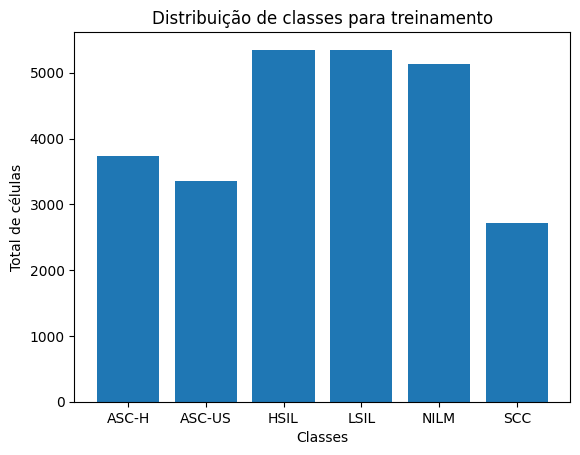

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize a dictionary to store the class counts
class_counts = {class_name: 0 for class_name in dataset.class_names}

# Iterate through the final_dataset to count occurrences of each class
for images, labels in final_dataset:
    labels = np.argmax(labels.numpy(), axis=1)  # Convert one-hot encoded labels to class indices
    for label in labels:
        class_name = dataset.class_names[label]
        class_counts[class_name] += 1

# Print class counts
print("Class distribution in the final dataset (after augmentation):")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")
labels = ['ASC-H', 'ASC-US', 'HSIL', 'LSIL', 'NILM', 'SCC']



# Plot a bar chart of the class distribution
plt.bar(labels, class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Total de células')
plt.title('Distribuição de classes para treinamento')
plt.show()

## Class weights

In [15]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Create a list of class labels (these correspond to indices used in training)
class_labels = list(class_counts.keys())
class_indices = np.array([class_labels.index(cls) for cls in class_labels])
class_samples = np.array([class_counts[cls] for cls in class_labels])

# Calculate the class weights
class_weights = compute_class_weight(
    'balanced',
    classes=class_indices,
    y=np.repeat(class_indices, class_samples)
)

# Convert the class weights into a dictionary to pass into the model during training
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Print the class weights
print("Class weights: ", class_weight_dict)


Class weights:  {0: 1.1432842481035252, 1: 1.2708829365079366, 2: 0.7996566791510612, 3: 0.7981619937694704, 4: 0.8328782263832001, 5: 1.5762889134982159}


# Training and comparisons

In [16]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0, InceptionV3, MobileNetV3Small, EfficientNetV2B0
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
import matplotlib.pyplot as plt

In [17]:
# List of models to compare
model_list = {
    'VGG16': VGG16,
    'ResNet50': ResNet50,
    'EfficientNetB0': EfficientNetB0,
    'InceptionV3': InceptionV3,
    'MobileNetV3Small': MobileNetV3Small,
    'EfficientNetV2B0': EfficientNetV2B0
}

# Function to build and compile a model
def build_model(model_name, input_shape=(100, 100, 3), num_classes=6):
    base_model = model_list[model_name](weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model layers

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    #InceptionV3 test
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

    # model.compile(optimizer=Adam(),
    #               loss='categorical_crossentropy',
    #               metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

    return model



In [18]:
# Train each model and store the results
model_results = {}

# Train each model
for model_name in model_list.keys():
    print(f"Training {model_name}...")

    # Build model
    model = build_model(model_name)

    # Callbacks for early stopping and saving the best model
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint(f'{model_name}_best_model.keras', monitor='val_loss', save_best_only=True)
    ]

    # Train the model
    history = model.fit(
        final_dataset,
        epochs=100,  # Adjust the number of epochs if necessary
        validation_data=val_dataset,
        class_weight=class_weight_dict,  # Apply class weights
        callbacks=callbacks
    )

    # Evaluate the model
    print(f"Evaluating {model_name} on validation set:")
    val_loss, val_acc, val_recall, val_precision = model.evaluate(val_dataset)

    # Example: Generate confusion matrix and ROC curve for one model (e.g., VGG16)
    print(f'Genearting predictions for {model_name} on validation set:')
    y_true = []  # Store true labels
    y_pred = []  # Store predicted labels
    y_pred_prob = []  # Store predicted probabilities for ROC curve

    # Get predictions from the trained model
    for images, labels in val_dataset:
        preds = model.predict(images)
        y_true.append(np.argmax(labels, axis=1))
        y_pred.append(np.argmax(preds, axis=1))
        y_pred_prob.append(preds)

    # Convert lists to numpy arrays
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    y_pred_prob = np.concatenate(y_pred_prob)

    # Save metrics for comparison
    model_results[model_name] = {
        'history': history,
        'model': model,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'val_recall': val_recall,
        'val_precision': val_precision,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_prob': y_pred_prob
    }

Training VGG16...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
    227/Unknown 23s 63ms/step - accuracy: 0.2903 - loss: 9.4770 - precision: 0.2906 - recall: 0.2886

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


234/234 ━━━━━━━━━━━━━━━━━━━━ 32s 103ms/step - accuracy: 0.2928 - loss: 9.4175 - precision: 0.2932 - recall: 0.2911 - val_accuracy: 0.5867 - val_loss: 3.4592 - val_precision: 0.5902 - val_recall: 0.5831
Epoch 2/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.4591 - loss: 4.0799 - precision: 0.4711 - recall: 0.4451 - val_accuracy: 0.5367 - val_loss: 1.2605 - val_precision: 0.6386 - val_recall: 0.3827
Epoch 3/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.4523 - loss: 1.5594 - precision: 0.5565 - recall: 0.3207 - val_accuracy: 0.6200 - val_loss: 1.0609 - val_precision: 0.7345 - val_recall: 0.4957
Epoch 4/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5151 - loss: 1.2958 - precision: 0.6310 - recall: 0.3840 - val_accuracy: 0.6303 - val_loss: 1.0443 - val_precision: 0.7516 - val_recall: 0.5151
Epoch 5/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.5605 - loss: 1.1472 - precision: 0.6788 - recall: 0.4496 - val_accuracy: 0.6191 - val_loss: 1.

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 49s 160ms/step - accuracy: 0.3304 - loss: 2.6319 - precision_4: 0.3619 - recall_4: 0.2411 - val_accuracy: 0.6146 - val_loss: 0.9629 - val_precision_4: 0.7444 - val_recall_4: 0.4903
Epoch 2/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5623 - loss: 1.0744 - precision_4: 0.6538 - recall_4: 0.4377 - val_accuracy: 0.6547 - val_loss: 0.8818 - val_precision_4: 0.7591 - val_recall_4: 0.5619
Epoch 3/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6149 - loss: 0.9375 - precision_4: 0.6920 - recall_4: 0.5181 - val_accuracy: 0.7073 - val_loss: 0.7824 - val_precision_4: 0.8028 - val_recall_4: 0.6105
Epoch 4/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6837 - loss: 0.8029 - precision_4: 0.7506 - recall_4: 0.5960 - val_accuracy: 0.7028 - val_loss: 0.7880 - val_precision_4: 0.7752 - val_recall_4: 0.6335
Epoch 5/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6

In [19]:
!pip install pydot
!apt-get install graphviz -y


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [21]:
from tensorflow.keras.utils import plot_model

# Assuming your model is already defined
# Example: model = tf.keras.applications.VGG16(weights='imagenet')

for key in model_results.keys():
  print(f"Model: {key}")
  model = model_results[key]['model']

  # Plot the model architecture
  plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

  # Display the model architecture image
  from IPython.display import Image
  Image('model.png')


Model: VGG16
Model: ResNet50
Model: EfficientNetB0
Model: InceptionV3
Model: MobileNetV3Small
Model: EfficientNetV2B0


In [18]:
for key in model_results.keys():
  model_results[key]['model'].summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 3, 3, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,259,032 (69.65 MB)

 Trainable params: 1,181,446 (4.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 2,362,898 (9.01 MB)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,758,936 (186.00 MB)

 Trainable params: 8,390,406 (32.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 16,780,818 (64.01 MB)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 4, 4, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 20480)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       5,243,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,783,611 (75.47 MB)

 Trainable params: 5,244,678 (20.01 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 10,489,362 (40.01 MB)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 1, 1, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,381,048 (89.19 MB)

 Trainable params: 526,086 (2.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 1,052,178 (4.01 MB)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)        │ (None, 4, 4, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,022,408 (30.60 MB)

 Trainable params: 2,361,094 (9.01 MB)

 Non-trainable params: 939,120 (3.58 MB)

 Optimizer params: 4,722,194 (18.01 MB)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)       │ (None, 4, 4, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 20480)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │       5,243,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,653,352 (82.60 MB)

 Trainable params: 5,244,678 (20.01 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 10,489,362 (40.01 MB)

## ROC Curve

In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Function to plot the ROC curve
def plot_roc_curve(y_true, y_pred_prob, class_names, model_name):
    # One-hot encode the true labels
    y_true_one_hot = label_binarize(y_true, classes=range(len(class_names)))

    classes_map = {
        'asch':'ASC-H',
        'ascus':'ASC-US',
        'hsil':'HSIL',
        'lsil':'LSIL',
        'normal':'NILM',
        'scc':'SCC',
    }

    fpr = {}
    tpr = {}
    roc_auc = {}

    plt.figure()
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'{classes_map[class_names[i]]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de falsos positivos')
    plt.ylabel('Taxa de verdadeiros positivos')
    plt.title(f'Curva ROC ({model_name})')
    plt.legend(loc='lower right')
    plt.show()

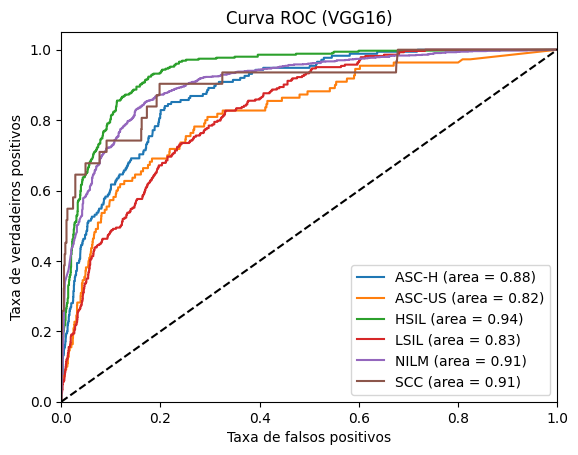

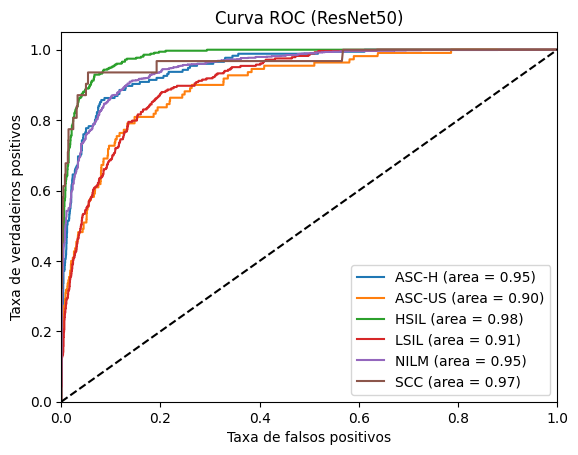

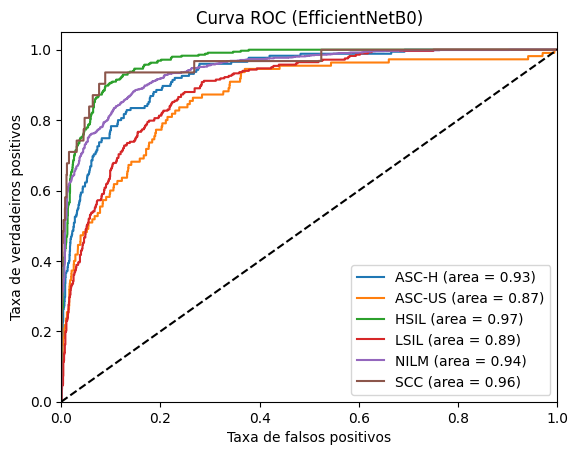

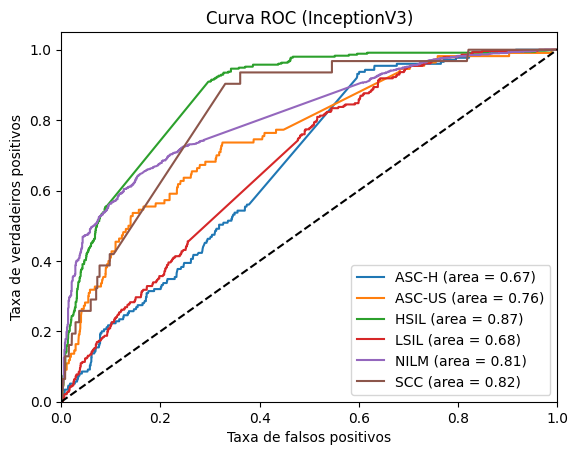

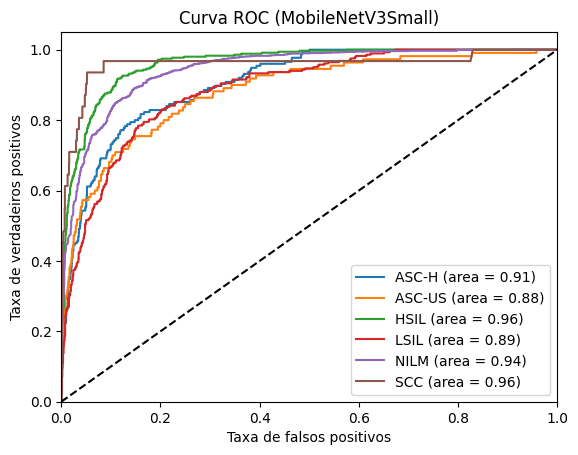

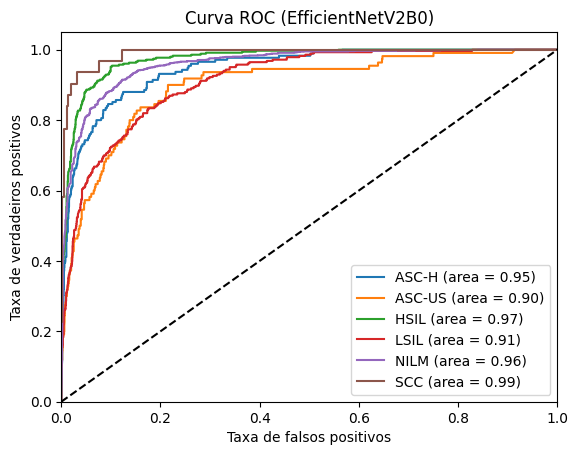

In [20]:
# # Example: Generate confusion matrix and ROC curve for one model (e.g., VGG16)
# y_true = []  # Store true labels
# y_pred = []  # Store predicted labels
# y_pred_prob = []  # Store predicted probabilities for ROC curve

# # Get predictions from the trained model
# for images, labels in val_dataset:
#     preds = model.predict(images)
#     y_true.append(np.argmax(labels, axis=1))
#     y_pred.append(np.argmax(preds, axis=1))
#     y_pred_prob.append(preds)

# # Convert lists to numpy arrays
# y_true = np.concatenate(y_true)
# y_pred = np.concatenate(y_pred)
# y_pred_prob = np.concatenate(y_pred_prob)

# Plot the ROC curve
for model_name, results in model_results.items():
  y_true = results['y_true']
  y_pred_prob = results['y_pred_prob']
  plot_roc_curve(y_true, y_pred_prob, dataset.class_names, model_name)

# Metrics extraction

## Confusion Matrix

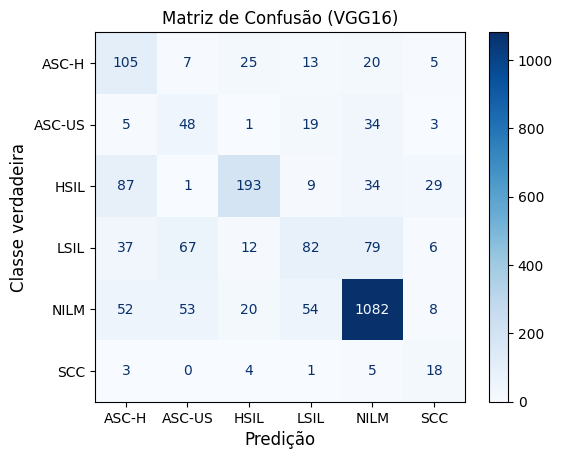

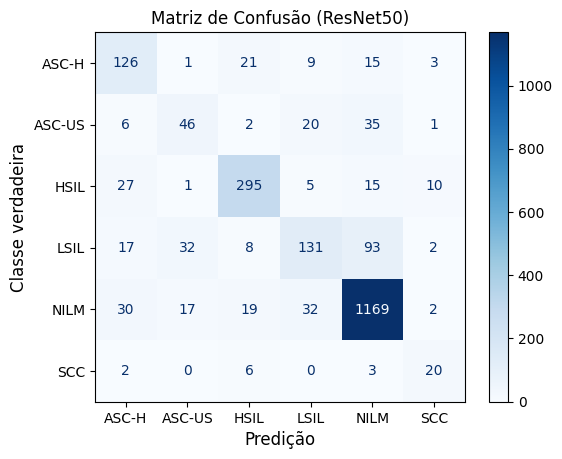

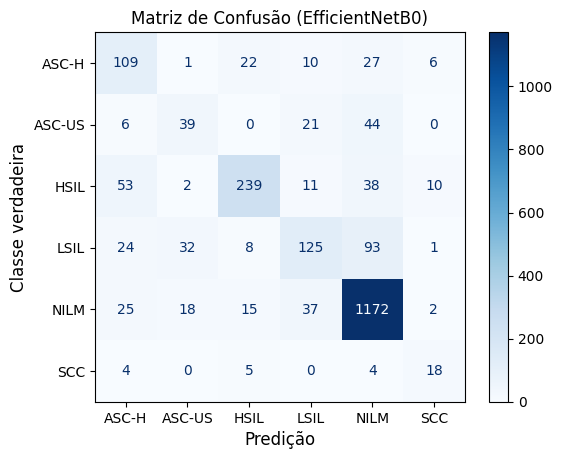

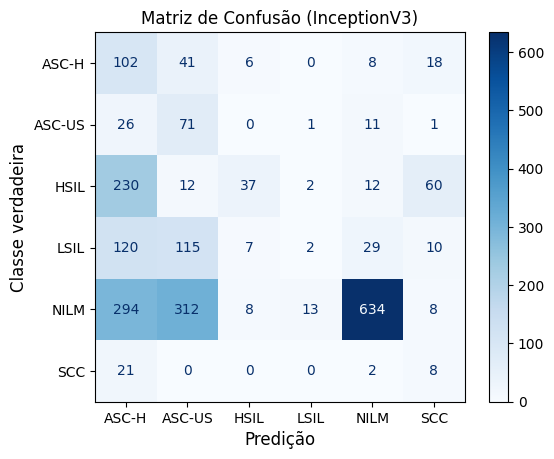

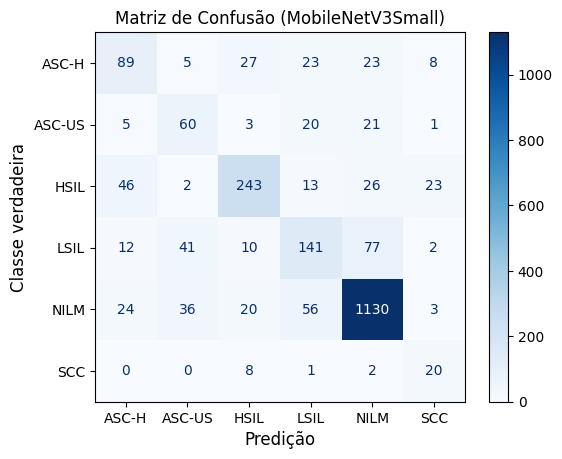

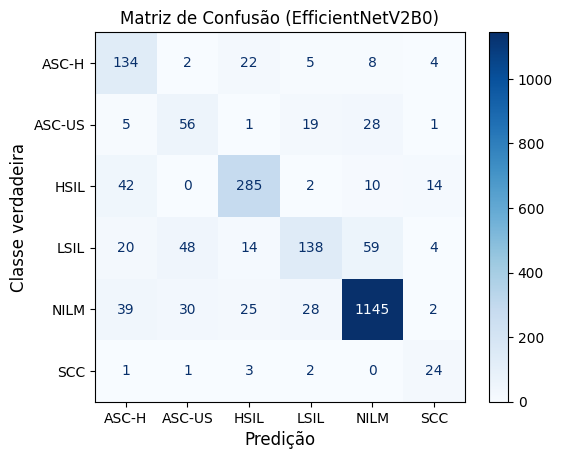

In [21]:
# Matriz de confusão

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    cm = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ASC-H', 'ASC-US', 'HSIL', 'LSIL', 'NILM', 'SCC'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Matriz de Confusão ({model_name})')
    plt.xlabel('Predição', fontsize=12)  # Customize x-axis label
    plt.ylabel('Classe verdadeira', fontsize=12)       # Customize y-axis label
    plt.show()

# Example: Generate confusion matrix for one model
# y_pred = []  # Store predicted labels

# # Get predictions from the trained model
# for images, labels in val_dataset:
#     preds = model.predict(images)
#     y_pred.append(np.argmax(preds, axis=1))

# # Convert lists to numpy arrays
# y_pred = np.concatenate(y_pred)

# model_list = {
#     'VGG16': VGG16,
#     'ResNet50': ResNet50,
#     'EfficientNetB0': EfficientNetB0,
#     'InceptionV3': InceptionV3,
#     'MobileNetV3Small': MobileNetV3Small,
#     'EfficientNetV2B0': EfficientNetV2B0
# }

# Plot the confusion matrix
for model_name, results in model_results.items():
  y_true = results['y_true']
  y_pred = results['y_pred']
  plot_confusion_matrix(y_true, y_pred, class_names=dataset.class_names, model_name=model_name)

## Accuracy and loss curves

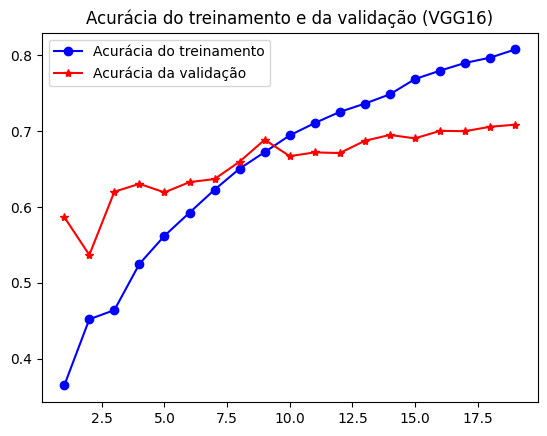

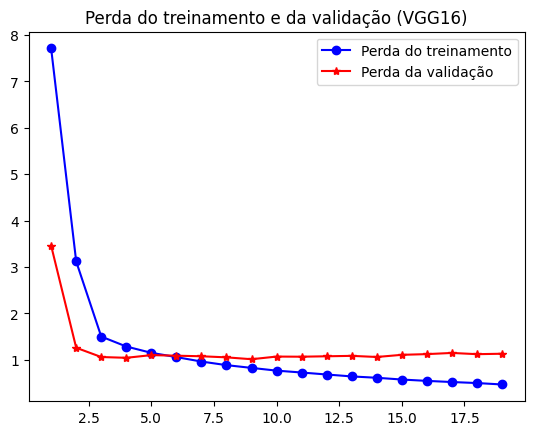

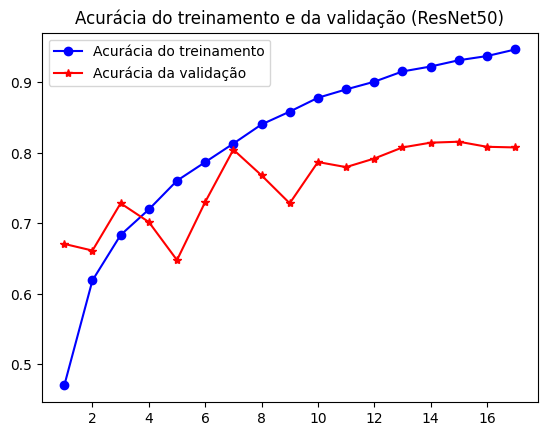

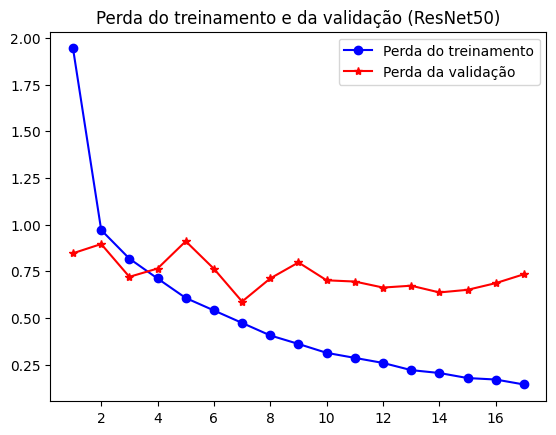

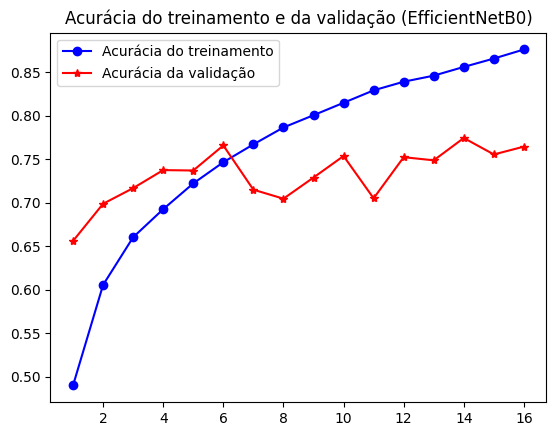

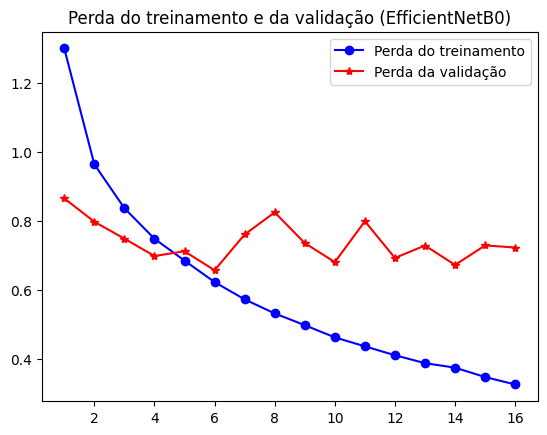

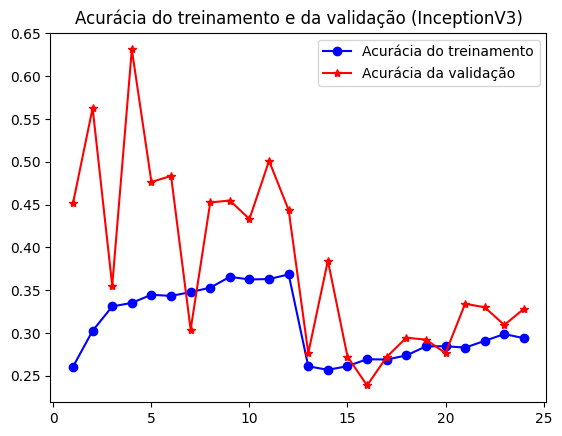

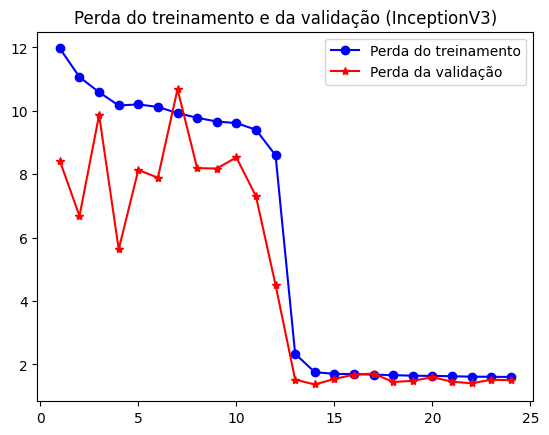

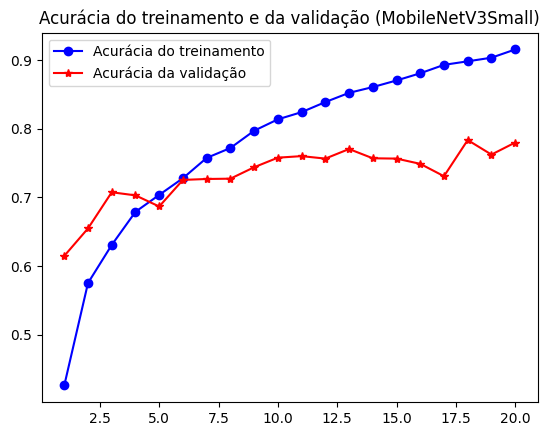

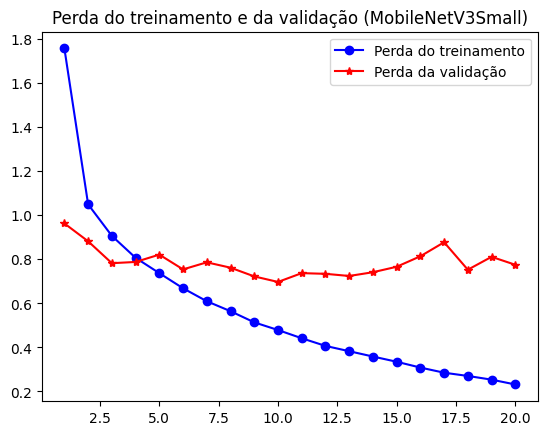

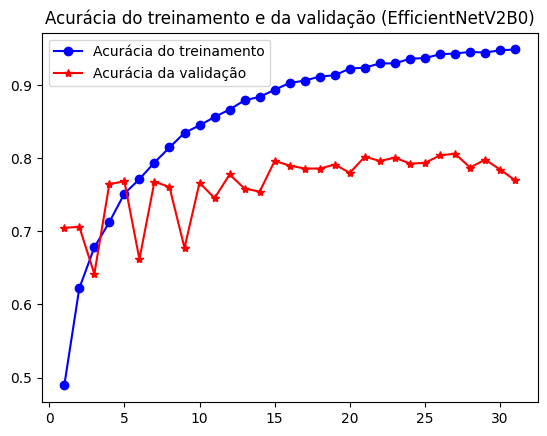

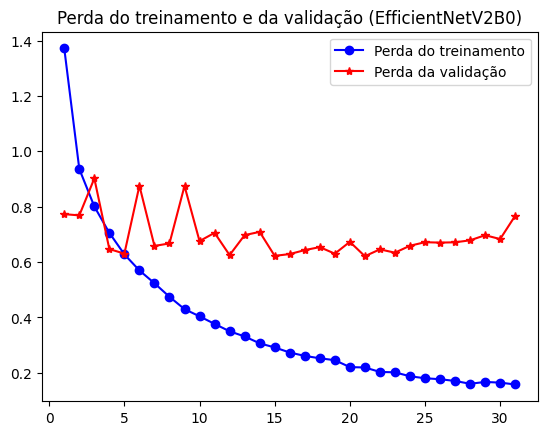

In [22]:
# Curva de perda e acurácia

# Function to plot loss and accuracy curves
def plot_loss_accuracy(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, acc, 'bo-', label='Acurácia do treinamento')
    plt.plot(epochs, val_acc, 'r*-', label='Acurácia da validação')
    plt.title(f'Acurácia do treinamento e da validação ({model_name})')
    plt.legend()
    plt.show()

    # Plot loss
    plt.figure()
    plt.plot(epochs, loss, 'bo-', label='Perda do treinamento')
    plt.plot(epochs, val_loss, 'r*-', label='Perda da validação')
    plt.title(f'Perda do treinamento e da validação ({model_name})')
    plt.legend()
    plt.show()

# model_list = {
#     'VGG16': VGG16,
#     'ResNet50': ResNet50,
#     'EfficientNetB0': EfficientNetB0,
#     'InceptionV3': InceptionV3,
#     'MobileNetV3Small': MobileNetV3Small,
#     'EfficientNetV2B0': EfficientNetV2B0
# }

# Example: Plot loss and accuracy for one model

for model_name, results in model_results.items():
  history = results['history']
  plot_loss_accuracy(history, model_name)


## Additional metrics

In [23]:
for model_name, results in model_results.items():
  y_true = results['y_true']
  y_pred = results['y_pred']

  # Calculate precision, recall, F1 score
  print(f"Classification Report for {model_name}:")
  print(classification_report(y_true, y_pred, target_names=dataset.class_names))

  # Calculate F1 Score
  f1 = f1_score(y_true, y_pred, average='weighted')  # Weighted F1 for multiclass
  print(f"Weighted F1 Score for {model_name}: {f1:.4f}")

Classification Report for VGG16:
              precision    recall  f1-score   support

        asch       0.36      0.60      0.45       175
       ascus       0.27      0.44      0.34       110
        hsil       0.76      0.55      0.63       353
        lsil       0.46      0.29      0.36       283
      normal       0.86      0.85      0.86      1269
         scc       0.26      0.58      0.36        31

    accuracy                           0.69      2221
   macro avg       0.50      0.55      0.50      2221
weighted avg       0.72      0.69      0.69      2221

Weighted F1 Score for VGG16: 0.6936
Classification Report for ResNet50:
              precision    recall  f1-score   support

        asch       0.61      0.72      0.66       175
       ascus       0.47      0.42      0.44       110
        hsil       0.84      0.84      0.84       353
        lsil       0.66      0.46      0.55       283
      normal       0.88      0.92      0.90      1269
         scc       0.53    

In [ ]:
model = model_results['VGG16']['model']

# Pass some dummy input to the model to "call" it and define its layers
input_shape = (1, 100, 100, 3)  # Adjust this to match your model input shape
dummy_input = tf.random.normal(input_shape)

# Call the model with dummy input to initialize its layers
model(dummy_input)

for idx, layer in enumerate(model.layers):
    print(f"{idx}: {layer.name} -> {layer.output_shape}")

NameError: name 'model_results' is not defined

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# Load a pre-trained model (e.g., VGG16, ResNet, EfficientNet)
#model = model_results['VGG16']['model']

# Choose the layer to visualize (usually the last convolutional layer)
layer_name = 'dense_1'
grad_model = Model(
    inputs=[model.inputs],
    outputs=[model.get_layer(layer_name).output, model.output]
)

# Function to compute the Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Get the gradients of the class output with respect to the feature maps of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Get the gradient of the class score with respect to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Compute the mean intensity of the gradient over each feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply the gradient values with the feature map values (importance weighting)
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Function to display the heatmap over the image
def display_gradcam(img_path, heatmap, alpha=0.4):
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Resize the heatmap to match the image size
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.expand_dims(heatmap, axis=-1)
    heatmap = np.tile(heatmap, [1, 1, 3])

    heatmap = tf.image.resize(heatmap, (img.shape[0], img.shape[1]))
    heatmap = np.uint8(heatmap.numpy())

    # Apply the heatmap to the image
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.uint8(superimposed_img)

    # Display the image
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Example usage
img_path = f'{base_path}/asch/10_9ae8a4edde40219bad6303cebc672ee4.png'  # Provide the image path
img_array = tf.keras.preprocessing.image.img_to_array(
    tf.keras.preprocessing.image.load_img(img_path, target_size=(100, 100))
)
img_array = np.expand_dims(img_array, axis=0)

# Generate the Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, grad_model, layer_name)

# Display the image with the heatmap superimposed
display_gradcam(img_path, heatmap)


ValueError: The layer sequential has never been called and thus has no defined output.